# **Import Library**

In [ ]:
!pip install pandas nltk tensorflow scikit-learn
!pip install sastrawi

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import pandas as pd
import re
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import geopandas as gpd
import matplotlib.pyplot as plt
import plotly.express as px
import folium
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from tqdm import tqdm
from collections import Counter
from google.colab import drive
from wordcloud import WordCloud
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
import nltk
from nltk.corpus import stopwords
import json
from sklearn.model_selection import train_test_split
import tensorflow as tf

# **Load Dataset**

In [ ]:
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/TA_Analisis_Sentimen/Akhir_Sendiri_Sudah_DIlabeli_dengan_sentimen.csv'

df = pd.read_csv(file_path, delimiter=';')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Praprocessing**

In [ ]:
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+|https t|t co', '', text, flags=re.MULTILINE) 
    text = re.sub(r'@\w+|\#\w+', '', text)  
    text = re.sub(r'[^a-zA-Z\s]', '', text) 
    text = text.strip()                     
    return text

def case_folding(text):
    return text.lower()

def tokenize_text(text):
    return text.split()

def normalize_text(tokens):
    abbreviation_dict = {
        'gk': 'nggak', 'ga': 'nggak', 'g': 'nggak','ngga': 'nggak', 'dlm': 'dalam', 'dgn': 'dengan', 'krn': 'karena', 'sdh': 'sudah', 'udh': 'sudah',
        'blm': 'belum', 'aja': 'saja', 'sy': 'saya', 'aku': 'saya', 'q': 'saya', 'kamu': 'anda', 'km': 'kamu',
        'bgt': 'banget', 'trs': 'terus', 'sm': 'sama', 'org': 'orang', 'jg': 'juga', 'bs': 'bisa', 'gmn': 'gimana',
        'gimana': 'bagaimana', 'tp': 'tapi', 'y': 'ya', 'smg': 'semoga', 'hrs': 'harus', 'lbh': 'lebih', 'jgn': 'jangan',
        'pd': 'pada', 'utk': 'untuk', 'gmana': 'bagaimana', 'klu': 'kalau', 'klo': 'kalau', 'dl': 'dulu', 'dtg': 'datang',
        'bgmn': 'bagaimana', 'nih': 'ini', 'pls': 'tolong', 'btw': 'ngomong-ngomong', 'ya': 'iya', 'si': 'sih',
        'brp': 'berapa', 'tmn': 'teman', 'bbrp': 'beberapa', 'trmksh': 'terima kasih', 'makasih': 'terima kasih',
        'mks': 'makasih', 'sblm': 'sebelum', 'mo': 'mau', 'mlm': 'malam', 'pagi': 'selamat pagi',
        'siang': 'selamat siang', 'sore': 'selamat sore', 'malem': 'malam', 'ok': 'oke', 'oke': 'baik',
        'thx': 'terima kasih', 'wkwk': 'tertawa', 'lol': 'tertawa', 'he': 'haha', 'ah': 'ah', 'gt': 'gitu',
        'om': 'paman', 'pak': 'bapak', 'bu': 'ibu', 'dr': 'dokter', 'msh': 'masih', 'kl': 'kalau', 'kmrn': 'kemarin',
        'bsk': 'besok', 'gw': 'saya', 'loe': 'kamu', 'loh': 'lho', 'n': 'dan', 'yg': 'yang', 'knp': 'kenapa', 'tdk': 'tidak'
    }
    return [abbreviation_dict.get(word, word) for word in tokens]

nltk.download('stopwords')

stop_words_id = set(stopwords.words('indonesian'))

def remove_stopwords(tokens):
    return [word for word in tokens if word not in stop_words_id]

def sastrawi_stem(tokens):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    return [stemmer.stem(word) for word in tokens]

df['cleaned_text'] = df['full_text'].apply(clean_text)
df['lowered_text'] = df['cleaned_text'].apply(case_folding)
df['tokenized_text'] = df['lowered_text'].apply(tokenize_text)
df['normalized_text'] = df['tokenized_text'].apply(normalize_text)
df['filtered_text'] = df['normalized_text'].apply(remove_stopwords)
df['stemmed_text'] = df['filtered_text'].apply(sastrawi_stem)  
df['processed_text'] = df['stemmed_text'].apply(lambda tokens: ' '.join(tokens)) 


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
display(df)

,full_text,Location,Sentimen,cleaned_text,lowered_text,tokenized_text,normalized_text,filtered_text,stemmed_text,processed_text
0,Uda Tomi dan Uda Andika ini harusnya diangkat ...,"Sumatera Barat, Indonesia",Negatif,Uda Tomi dan Uda Andika ini harusnya diangkat ...,uda tomi dan uda andika ini harusnya diangkat ...,"[uda, tomi, dan, uda, andika, ini, harusnya, d...","[uda, tomi, dan, uda, andika, ini, harusnya, d...","[uda, tomi, uda, andika, diangkat, pns, basarn...","[uda, tom, uda, andika, angkat, pns, basarnas,...",uda tom uda andika angkat pns basarnas sih jal...
1,aku belum pernah nanjak terhalang restu orang ...,"Sumatera Barat, Indonesia",Negatif,aku belum pernah nanjak terhalang restu orang ...,aku belum pernah nanjak terhalang restu orang ...,"[aku, belum, pernah, nanjak, terhalang, restu,...","[saya, belum, pernah, nanjak, terhalang, restu...","[nanjak, terhalang, restu, orang, tua, gunung,...","[nanjak, halang, restu, orang, tua, gunung, ma...",nanjak halang restu orang tua gunung marapi er...
2,Kucing emas korban jerat kini bebas. Namun men...,"Sumatera Barat, Indonesia",Negatif,Kucing emas korban jerat kini bebas Namun meng...,kucing emas korban jerat kini bebas namun meng...,"[kucing, emas, korban, jerat, kini, bebas, nam...","[kucing, emas, korban, jerat, kini, bebas, nam...","[kucing, emas, korban, jerat, bebas, hewan, la...","[kucing, emas, korban, jerat, bebas, hewan, la...",kucing emas korban jerat bebas hewan langka ha...
3,Pas banget pertama turun ke payakumbuh itu kit...,"Payakumbuh, Sumatera Barat",Negatif,Pas banget pertama turun ke payakumbuh itu kit...,pas banget pertama turun ke payakumbuh itu kit...,"[pas, banget, pertama, turun, ke, payakumbuh, ...","[pas, banget, pertama, turun, ke, payakumbuh, ...","[pas, banget, turun, payakumbuh, rencanain, ta...","[pas, banget, turun, payakumbuh, rencanain, ta...",pas banget turun payakumbuh rencanain tanggal ...
4,Hal yang paling aku takutkan saat ini apalagi ...,"Jakarta, Indonesia",Negatif,Hal yang paling aku takutkan saat ini apalagi ...,hal yang paling aku takutkan saat ini apalagi ...,"[hal, yang, paling, aku, takutkan, saat, ini, ...","[hal, yang, paling, saya, takutkan, saat, ini,...","[takutkan, temenku, korban, erupsi, marapi, se...","[takut, temenku, korban, erupsi, marapi, moga,...",takut temenku korban erupsi marapi moga selamat
...,...,...,...,...,...,...,...,...,...,...
983,Gunung Sinabung Meletus 2 Kali Gunung Marapi E...,"Sumatera Barat, Indonesia",Negatif,Gunung Sinabung Meletus Kali Gunung Marapi Er...,gunung sinabung meletus kali gunung marapi er...,"[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sabung, letus, kali, gunung, marapi, ...",gunung sabung letus kali gunung marapi erupsi ...
984,Gunung Sinabung Meletus 2 Kali Gunung Marapi E...,"Garut, Indonesia",Negatif,Gunung Sinabung Meletus Kali Gunung Marapi Er...,gunung sinabung meletus kali gunung marapi er...,"[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sinabung, meletus, kali, gunung, mara...","[gunung, sabung, letus, kali, gunung, marapi, ...",gunung sabung letus kali gunung marapi erupsi ...
985,Marapi Keluarkan Asap Hitam Warga Khawatir: En...,"Sumatera Barat, Indonesia",Negatif,Marapi Keluarkan Asap Hitam Warga Khawatir Ena...,marapi keluarkan asap hitam warga khawatir ena...,"[marapi, keluarkan, asap, hitam, warga, khawat...","[marapi, keluarkan, asap, hitam, warga, khawat...","[marapi, keluarkan, asap, hitam, warga, khawat...","[marapi, keluar, asap, hitam, warga, khawatir,...",marapi keluar asap hitam warga khawatir enam m...
986,Marapi Keluarkan Asap Hitam Warga Khawatir: En...,"Sumatera Barat, Indonesia",Negatif,Marapi Keluarkan Asap Hitam Warga Khawatir Ena...,marapi keluarkan asap hitam warga khawatir ena...,"[marapi, keluarkan, asap, hitam, warga, khawat...","[marapi, keluarkan, asap, hitam,

# **TF-IDF**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X = tfidf_vectorizer.fit_transform(df['processed_text'])

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['Sentimen'])


# **SMOTE dan Modeling**

In [ ]:
kernel_results = {}

kernels = ['linear', 'poly', 'rbf']

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

for kernel in kernels:
    scores = {
        'accuracy': [],
        'precision': [],
        'recall': [],
        'f1_score': []
    }

    for train_index, test_index in kf.split(X, y):
       
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        pipeline = ImbPipeline([
            ('svm', SVC(C=1, kernel=kernel, gamma='scale'))
        ])

        pipeline.fit(X_train_resampled, y_train_resampled)

        y_pred = pipeline.predict(X_test)

        scores['accuracy'].append(accuracy_score(y_test, y_pred))
        scores['precision'].append(precision_score(y_test, y_pred, average='weighted'))
        scores['recall'].append(recall_score(y_test, y_pred, average='weighted'))
        scores['f1_score'].append(f1_score(y_test, y_pred, average='weighted'))

    kernel_results[kernel] = {metric: sum(values) / len(values) for metric, values in scores.items()}

# **Evaluasi**

In [ ]:
for kernel, metrics in kernel_results.items():
    print(f"Kernel: {kernel}")
    for metric, score in metrics.items():
        print(f"{metric.capitalize()}: {score:.4f}")
    print("\n" + "-" * 50 + "\n")

Kernel: linear
Accuracy: 0.9069
Precision: 0.9065
Recall: 0.9069
F1_score: 0.9052

--------------------------------------------------

Kernel: poly
Accuracy: 0.8938
Precision: 0.8975
Recall: 0.8938
F1_score: 0.8834

--------------------------------------------------

Kernel: rbf
Accuracy: 0.9089
Precision: 0.9117
Recall: 0.9089
F1_score: 0.9021

--------------------------------------------------



# **Visualisasi**

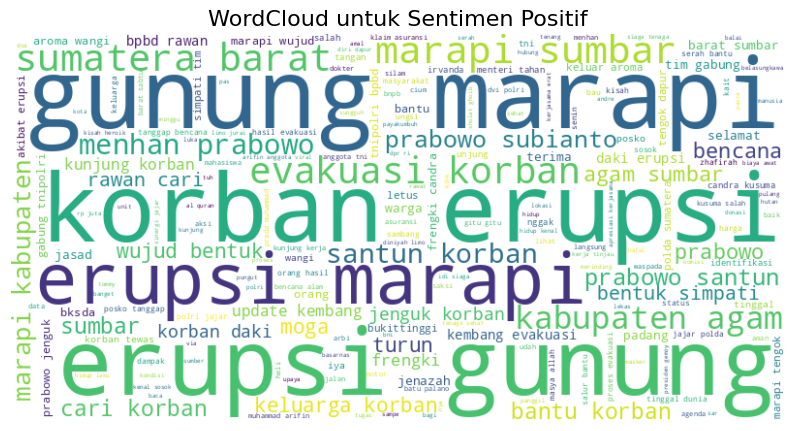

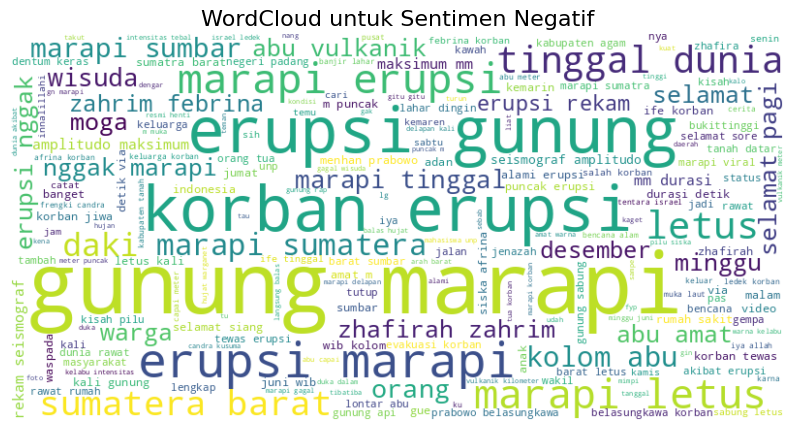

In [ ]:
def generate_wordcloud_by_sentiment(df, sentiment_label):
  
    filtered_df = df[df['Sentimen'] == sentiment_label]

    text = " ".join(filtered_df['processed_text'])

    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'WordCloud untuk Sentimen {sentiment_label}', fontsize=16)
    plt.show()

generate_wordcloud_by_sentiment(df, 'Positif')
generate_wordcloud_by_sentiment(df, 'Negatif')

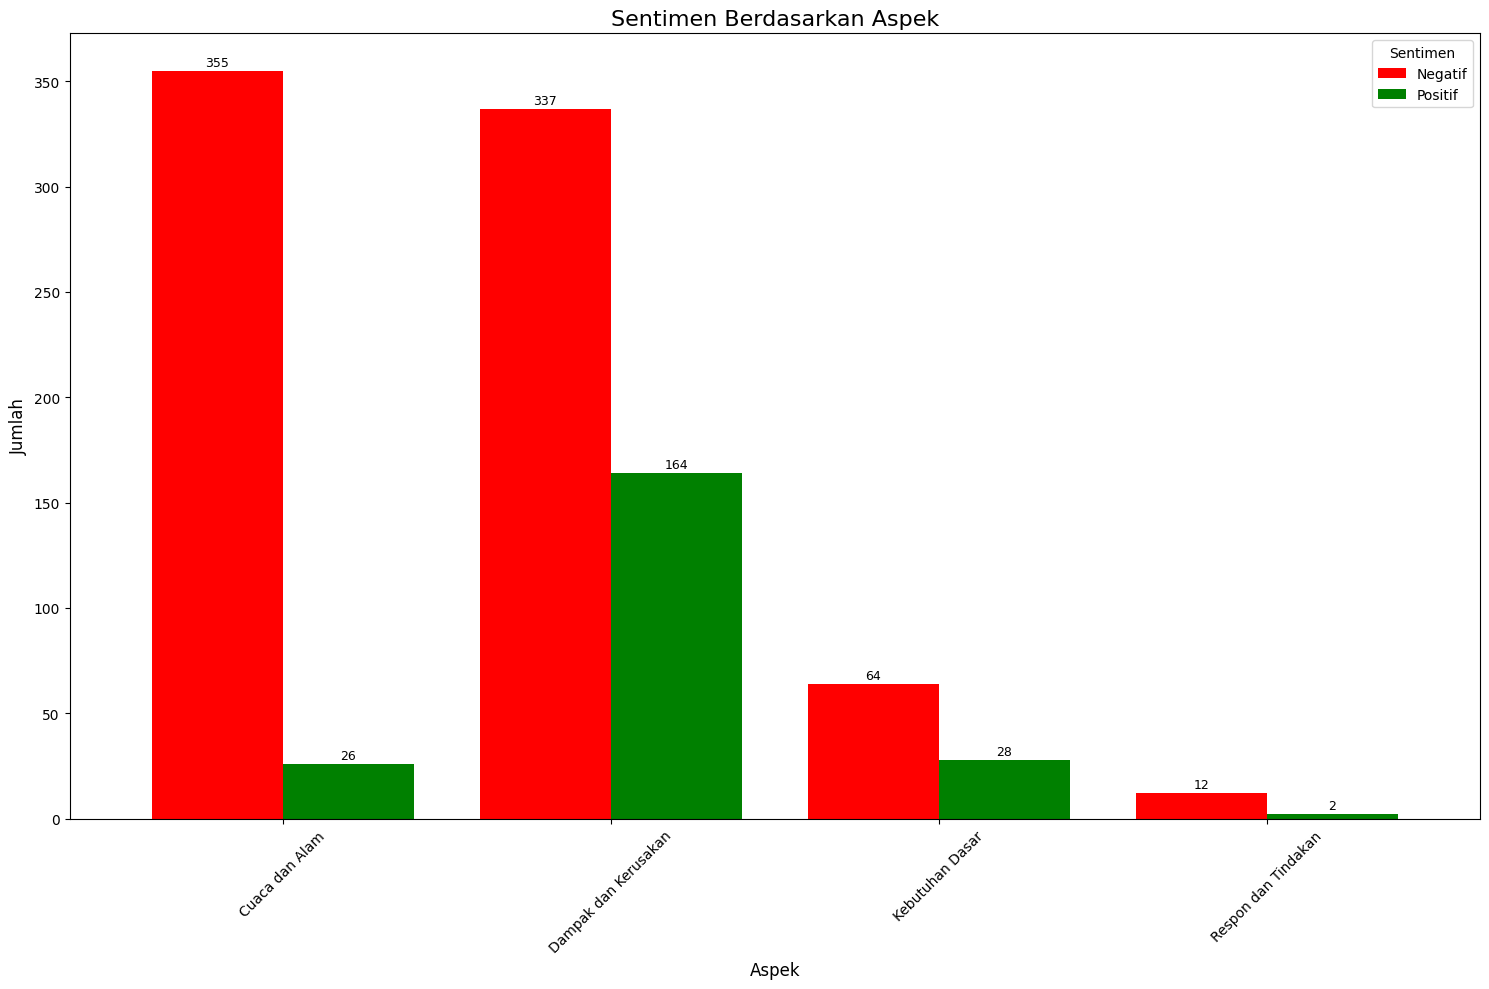

In [ ]:
aspect_keywords = {
    'Kebutuhan Dasar': [
        'Tempat tinggal', 'hunian', 'rumah', 'pengungsian', 'bangun', 'pemukiman', 'bangunan',
        'medis', 'obat', 'sakit', 'penyakit', 'kesehatan', 'dokter', 'masker',
        'makan', 'bahan pokok', 'lapar', 'pangan', 'makanan', 'dapur', 'Dapur', 'sembako',
        'air', 'minum', 'haus',
        'listrik', 'padam',
        'jalan', 'transportasi'
    ],
    'Dampak dan Kerusakan': [
        'kerugian', 'dampak', 'kerusakan', 'hilang', 'bangunan', 'rumah', 'korban', 'meninggal', 'luka', 'jiwa', 'selamat'
    ],
    'Respon dan Tindakan': [
        'santunan', 'bantuan', 'bantuan sosial', 'penyelamatan', 'relawan', 'sar', 'evakuasi', 'pertolongan',
        'membantu', 'mengevakuasi', 'asuransi'
    ],
    'Cuaca dan Alam': [
        'cuaca', 'hujan', 'tanah', 'gunung', 'pohon', 'abu', 'abuu', 'asap', 'siang', 'malam', 'pagi', 'sore', 'jurang',
        'erupsi', 'banjir', 'membaik', 'sembuh', 'longsor', 'vulkanik', 'gunuang', 'meletus', 'gempa'
    ]
}

df['processed_text'] = df['full_text']

def classify_aspect(text):
    for aspect, keywords in aspect_keywords.items():
        for keyword in keywords:
            if keyword.lower() in text.lower():
                return aspect
    return 'Lainnya'  

df['Aspect'] = df['processed_text'].apply(classify_aspect)

aspect_sentiment_counts = df.groupby(['Aspect', 'Sentimen']).size().unstack(fill_value=0)

fig, ax = plt.subplots(figsize=(15, 10))

aspect_sentiment_counts.plot(kind='bar', ax=ax, color=['red', 'green'], width=0.8)

for i, bar in enumerate(ax.patches):
    if bar.get_height() > 0:  
        ax.text(
            bar.get_x() + bar.get_width() / 2,  
            bar.get_height() + 1,  
            int(bar.get_height()),  
            ha='center', va='bottom', fontsize=9  
        )

ax.set_title("Sentimen Berdasarkan Aspek", fontsize=16)
ax.set_xlabel("Aspek", fontsize=12)
ax.set_ylabel("Jumlah", fontsize=12)
ax.legend(["Negatif", "Positif"], title="Sentimen", fontsize=10)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()

plt.show()

In [ ]:
from geopy.exc import GeocoderTimedOut, GeocoderQueryError
import folium
import pandas as pd
from IPython.display import display  

def get_coordinates(location):
    try:
        if not location or pd.isna(location):
            return None  
        loc = geolocator.geocode(location, timeout=10)
        if loc:
            return loc.latitude, loc.longitude
        else:
            return None
    except (GeocoderTimedOut, GeocoderQueryError) as e:
        print(f"Error mendapatkan koordinat untuk lokasi: {location} | Error: {e}")
        return None

df['Coordinates'] = df['Location'].apply(get_coordinates)

df['Latitude'] = df['Coordinates'].apply(lambda x: x[0] if x else None)
df['Longitude'] = df['Coordinates'].apply(lambda x: x[1] if x else None)

df['Latitude'] = df['Latitude'].fillna(0)  
df['Longitude'] = df['Longitude'].fillna(0)  

aspect_sentimen_aggregated = df.groupby(['Aspect', 'Location', 'Sentimen']).size().unstack(fill_value=0)
aspect_sentimen_aggregated['Dominant_Sentimen'] = aspect_sentimen_aggregated.idxmax(axis=1)  # Sentimen terbanyak
aspect_sentimen_aggregated = aspect_sentimen_aggregated.reset_index()

location_coordinates = df.groupby('Location')[['Latitude', 'Longitude']].mean().reset_index()
map_data = pd.merge(aspect_sentimen_aggregated, location_coordinates, on='Location', how='left')

aspects = ['Kebutuhan Dasar', 'Dampak dan Kerusakan', 'Respon dan Tindakan', 'Cuaca dan Alam']

maps = {}

for aspect in aspects:
    
    aspect_data = map_data[map_data['Aspect'] == aspect]

    m = folium.Map(location=[-2.5489, 118.0149], zoom_start=5, tiles="cartodb positron")

    for _, row in aspect_data.iterrows():
        folium.CircleMarker(
            location=(row['Latitude'], row['Longitude']),
            radius=8,
            color='blue' if row['Dominant_Sentimen'] == 'Positif' else 'red',
            fill=True,
            fill_opacity=0.6,
            popup=f"Lokasi: {row['Location']}<br>Aspek: {row['Aspect']}<br>Sentimen Dominan: {row['Dominant_Sentimen']}"
        ).add_to(m)

    maps[aspect] = m



In [ ]:
display(maps['Kebutuhan Dasar'])

In [ ]:
display(maps['Dampak dan Kerusakan'])

In [ ]:
display(maps['Respon dan Tindakan'])

In [ ]:
display(maps['Cuaca dan Alam'])